In [1]:
import numpy as np
import pandas as pd
import pyranges as pr
import gget
import glob
import networkx as nx
from scipy.stats import entropy
import os
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from importlib import reload

# locals 
import regulatory_network as grn
import isoforms as iso

In [2]:
reload(iso)

fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/isoquant_prepared/isoforms.csv"
df = iso.load_isoquant(fpath)
print(f"{df.shape=}")
df.head()

df.shape=(27974, 13)


,gene_id,gene_name,gene_biotype,transcript_id,transcript_name,transcript_biotype,gene_counts,transcript_counts,gene_CPM,log_CPM,n_isoforms,tid,short_name
241462,ENSG00000128274,A4GALT,protein_coding,ENST00000249005,A4GALT-201,protein_coding,2144,9,23.041880,3.179797,4,1,201
241463,ENSG00000128274,A4GALT,protein_coding,ENST00000381278,A4GALT-202,protein_coding,2144,32,23.041880,3.179797,4,2,202
241460,ENSG00000128274,A4GALT,protein_coding,ENST00000401850,A4GALT-203,protein_coding,2144,2,23.041880,3.179797,4,3,203
241461,ENSG00000128274,A4GALT,protein_coding,ENST00000642412,A4GALT-206,protein_coding,2144,89,23.041880,3.179797,4,4,206
156088,ENSG00000094914,AAAS,protein_coding,ENST00000209873,AAAS-201,protein_coding,918,29,9.865879,2.385628,3,1,201


/tmp/ipykernel_3935004/2441374878.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf, ec='k', palette=['#40E0D0', '#FF7F50'])


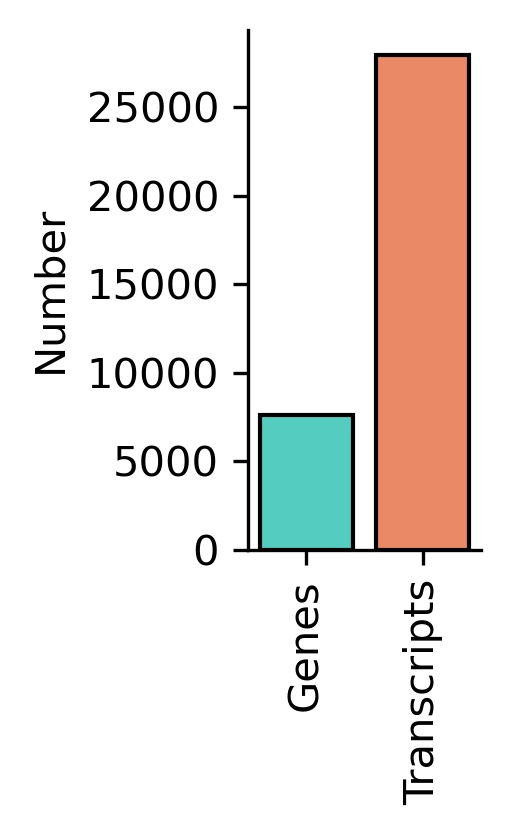

In [41]:
pdf = df.copy()

pdf = pdf[pdf['transcript_counts'] > 0]

pdf = pdf[['gene_name', 'transcript_name']].nunique()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1, 2.25

sns.barplot(data=pdf, ec='k', palette=['#40E0D0', '#FF7F50'])
plt.ylabel("Number")
plt.xlabel("")

ax = plt.gca()
ax.set_xticklabels(["Genes", "Transcripts"])
ax.tick_params(axis='x', rotation=90)
sns.despine()

# Isoforms per gene

In [43]:
pdf = df.copy()

pdf = pdf.groupby('gene_name').agg(
    n_isoforms = ('transcript_name', 'nunique'),
    mean_counts = ('transcript_counts', 'mean'),
    std_counts = ('transcript_counts', 'std'),
).reset_index().fillna(0)

pdf.head()

,gene_name,n_isoforms,mean_counts,std_counts
0,A4GALT,4,33.000000,39.471509
1,AAAS,3,15.666667,12.220202
2,AAGAB,4,100.250000,165.998745
3,AAK1,3,398.000000,678.112822
4,AAMDC,6,1854.000000,2844.197813


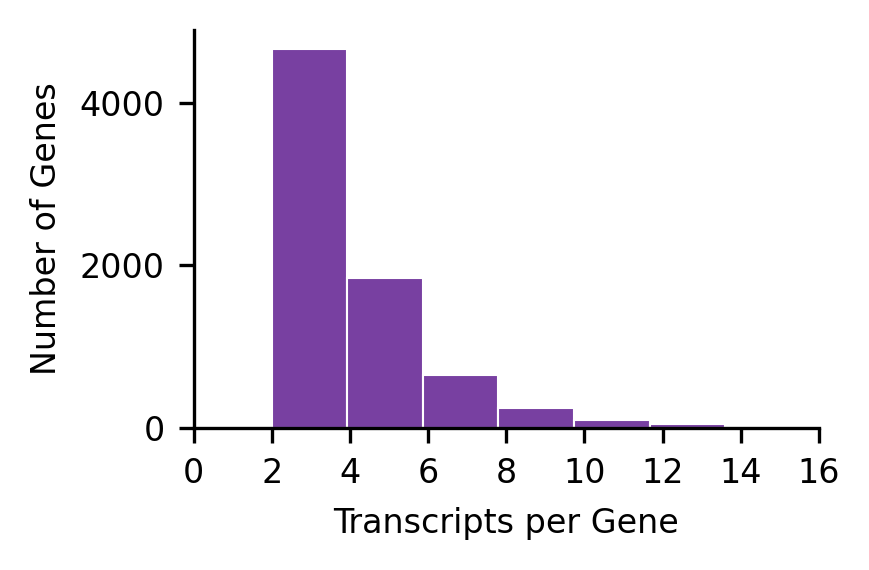

In [50]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2.


# Create the histogram with Seaborn
sns.histplot(
    data=pdf,
    bins=15,
    x='n_isoforms',
    color="#4B0082",  
    kde=False,        # Remove the KDE curve (density plot)
    edgecolor="white", # Add white edges to the bars for clarity
    linewidth=0.5    # Fine-tune the line width of the edges
)

plt.xlim([0, 16])

# Add labels and title
plt.xlabel('Transcripts per Gene', fontsize=8)
plt.ylabel('Number of Genes', fontsize=8)

# Customize tick labels
plt.xticks(range(0, 17, 2), fontsize=8)
plt.yticks(fontsize=8)

# Adjust layout to prevent overlapping labels
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()

# Reprogramming Factors

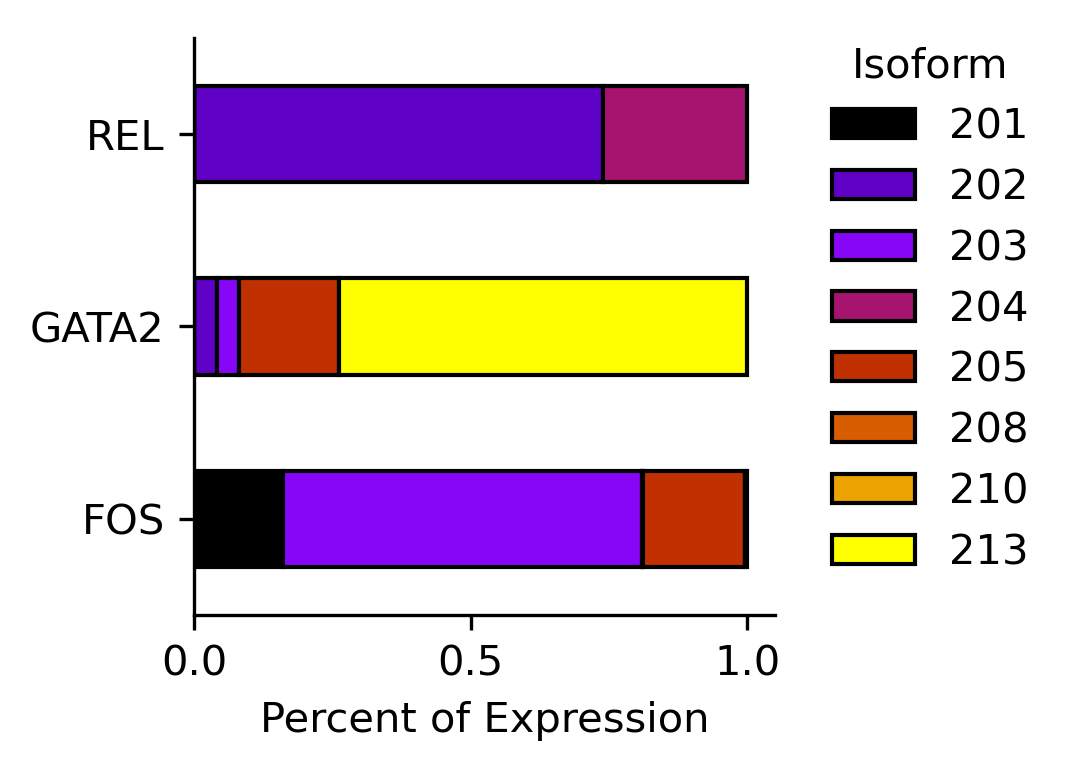

In [124]:
genes = ['GATA2', 'FOS', 'STAT5A', "REL", "GFI1B"]
table, pdf = iso.pivot_isoforms(df, genes=genes)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2.5, 2.5

default_isoform_kwargs = {
    'kind': 'barh',
    'stacked': True,
    'width': 0.5,
    'cmap': 'gnuplot',
    'ec': 'k'
}
table.plot(**default_isoform_kwargs)

plt.ylabel("")
plt.xlabel("Percent of Expression")

sns.move_legend(
    plt.gca(),
    loc='upper right',
    title="Isoform",
    frameon=False,
    bbox_to_anchor=(1.5, 1.05)
)

sns.despine()

In [125]:
pdf

,gene_id,gene_name,gene_biotype,transcript_id,transcript_name,transcript_biotype,gene_counts,transcript_counts,gene_CPM,log_CPM,n_isoforms,tid,short_name,tx_percent
164505,ENSG00000170345,FOS,protein_coding,ENST00000303562,FOS-201,protein_coding,11073,849,119.003140,4.787518,6,1,201,0.161468
164508,ENSG00000170345,FOS,protein_coding,ENST00000554212,FOS-203,protein_coding,11073,3403,119.003140,4.787518,6,2,203,0.647204
164506,ENSG00000170345,FOS,protein_coding,ENST00000554617,FOS-204,protein_coding,11073,18,119.003140,4.787518,6,3,204,0.003423
164510,ENSG00000170345,FOS,protein_coding,ENST00000555242,FOS-205,protein_coding,11073,962,119.003140,4.787518,6,4,205,0.182959
164511,ENSG00000170345,FOS,protein_coding,ENST00000555686,FOS-208,protein_coding,11073,3,119.003140,4.787518,6,5,208,0.000571
164513,ENSG00000170345,FOS,protein_coding,ENST00000557139,FOS-210,protein_coding,11073,23,119.003140,4.787518,6,6,210,0.004374
55731,ENSG00000179348,GATA2,protein_coding,ENST00000430265,GATA2-202,protein_coding,3297,19,35.433338,3.595484,4,1,202,0.040948
55732,ENSG00000179348,GATA2,protein_coding,ENST00000487848,GATA2-203,protein_coding,3297,19,35.433338,3.595484,4,2,203,0.040948
55733,ENSG00000179348,GATA2,protein_coding,ENST00000492608,GATA2-205,protein_coding,3297,84,35.433338,3.595484,4,3,205,0.181034
55727,ENSG00000179348,GATA2,protein_coding,ENST00000696672,GATA2-213,protein_coding,3297,342,35.433338,3.595484,4,4,213,0.737069


In [126]:
0.182959 + 0.161468 + 0.647204

0.991631

# Plots

88


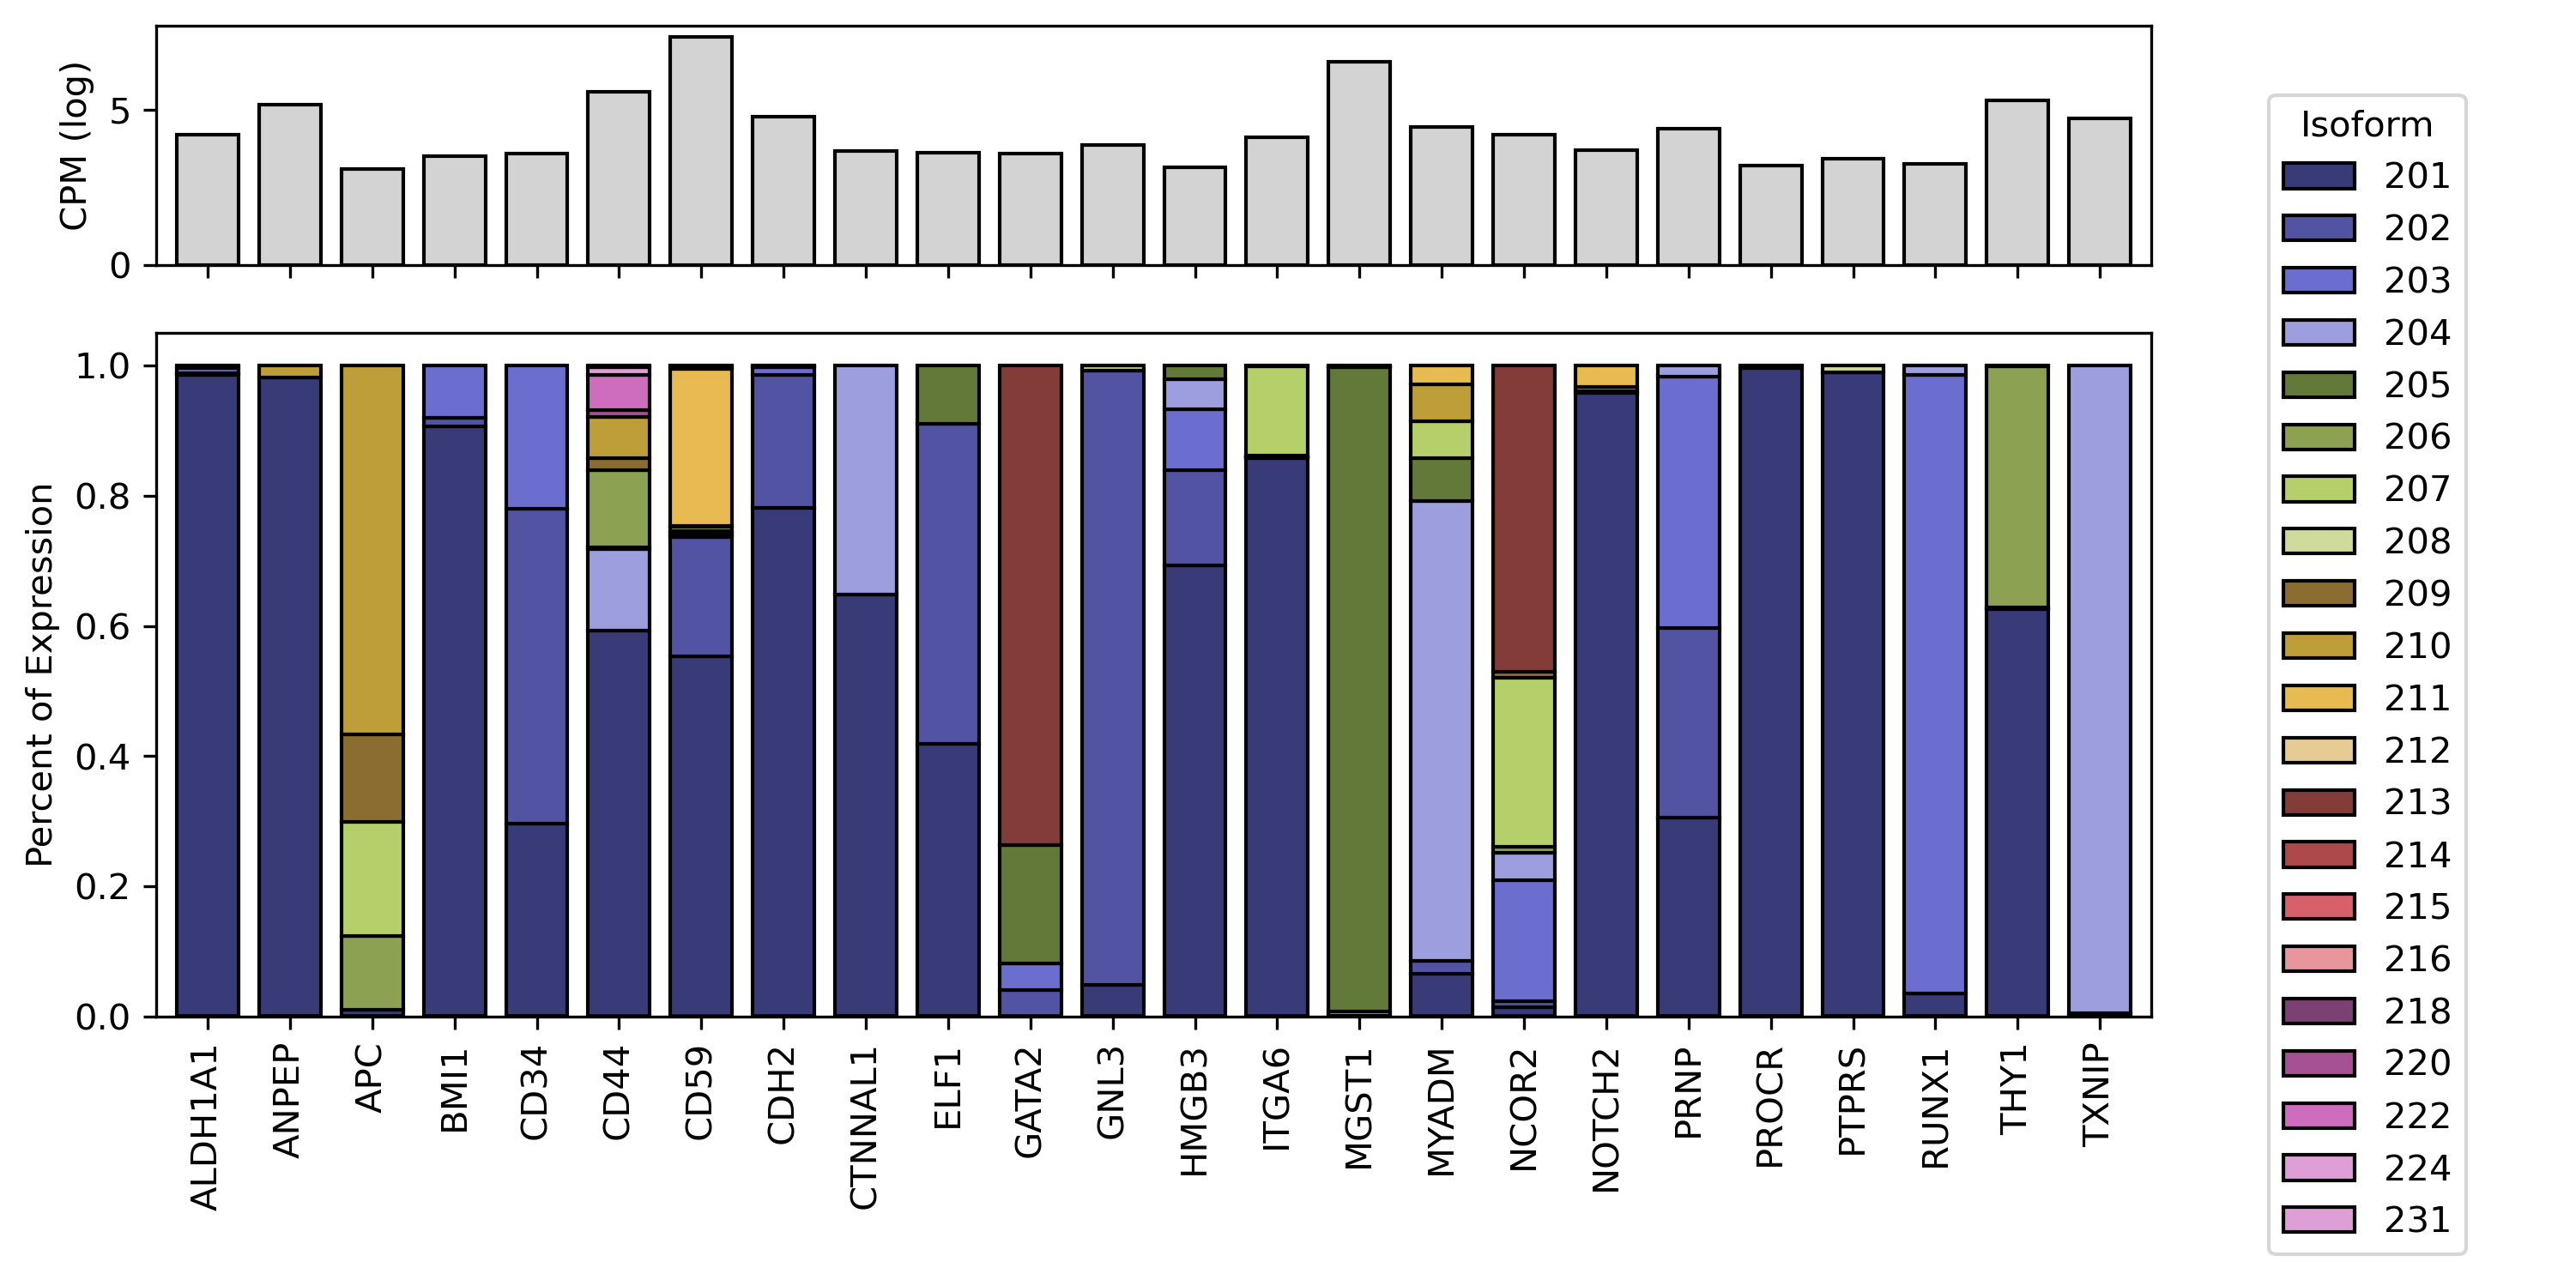

In [127]:
reload(iso)
    
pangloa = pd.read_csv("/home/cstansbu/git_repositories/ONT-single-cell/config/gene_annotations/panglaodb.csv")
cell_type = 'Hematopoietic stem cells'
genes = pangloa[pangloa['cell_type'] == cell_type]
genes = genes['gene_name'].values
print(len(genes))
    

pdf = df.copy()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 5
iso.plot_isoform_expression(df, genes, count_threshold=1000)

# Maintenance of pluripotency

In [182]:
pdf = df.copy()

pdf = pdf.groupby('gene_name').agg(
    n_isoforms = ('transcript_name', 'count'),
    mean_expression = ('transcript_counts', 'mean'),
    std_expression = ('transcript_counts', 'std'),
).reset_index()

pdf['rank'] = pdf['std_expression'].rank(ascending=False)
pdf = pdf.sort_values(by='rank')

pdf.head()

,gene_name,n_isoforms,mean_expression,std_expression,rank
5486,S100A6,4,668150.50,1.205364e+06,1.0
6436,TIMP1,5,141108.00,3.138762e+05,2.0
5478,S100A10,2,215995.50,3.051102e+05,3.0
5484,S100A4,4,194947.25,2.784097e+05,4.0
600,B2M,2,109445.50,1.547751e+05,5.0


In [195]:
# dpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/GO_annotations/"
# file_list = glob.glob(f"{dpath}*")

# pways = {}

# for file_path in file_list:
#     pway = os.path.basename(file_path).replace(".tsv", "")
#     tmp = pd.read_csv(file_path, sep='\t')
#     pways[pway] = list(tmp['SYMBOL'].unique())
    
# for k, v in pways.items():
#     print(k, len(v))

# Enrichment Analysis

In [173]:
pdf = df.copy()

pdf = pdf.groupby('gene_name').agg(
    n_isoforms = ('transcript_name', 'count'),
    mean_expression = ('transcript_counts', 'mean'),
    std_expression = ('transcript_counts', 'std'),
).reset_index()

print(f"{pdf.shape=}")

pdf = pdf.sort_values(by='std_expression', ascending=False)
pdf.head(15)

pdf.shape=(7614, 4)


,gene_name,n_isoforms,mean_expression,std_expression
5486,S100A6,4,668150.500000,1.205364e+06
6436,TIMP1,5,141108.000000,3.138762e+05
5478,S100A10,2,215995.500000,3.051102e+05
5484,S100A4,4,194947.250000,2.784097e+05
600,B2M,2,109445.500000,1.547751e+05
5687,SH3BGRL3,2,106762.000000,1.509517e+05
6575,TMSB4X,4,65955.500000,1.277056e+05
5630,SERF2,9,41341.000000,1.208290e+05
1383,COL1A1,2,77254.000000,1.091759e+05
4366,OST4,3,50234.666667,7.991041e+04


In [176]:
n = 100
query = list(pdf['gene_name'].head(n).values)
database = 'Tabula_Sapiens'
# database = "GO_Biological_Process_2023"

edf = gget.enrichr(query, database=database)
edf = edf[['path_name', 'adj_p_val', 'overlapping_genes']]
edf.head(10)

Thu Aug  1 15:47:01 2024 INFO Performing Enichr analysis using database Tabula_Sapiens.


,path_name,adj_p_val,overlapping_genes
0,Blood-macrophage,1.967941e-21,"[IFITM3, GPX1, ATP5F1E, MYL6, NACA, FTH1, TMSB..."
1,Bone Marrow-macrophage,1.967941e-21,"[IFITM3, GPX1, ATP5F1E, MYL6, NACA, FTH1, TMSB..."
2,Large Intestine-mature Enterocyte,1.967941e-21,"[AHNAK, COX4I1, EIF1, LGALS3, MYL6, KRT19, KRT..."
3,Uterus-pericyte Cell,1.967941e-21,"[IFITM3, SPARC, TPM2, EIF1, COL1A1, MYL6, NACA..."
4,Lung-lung Ciliated Cell,4.536597e-20,"[CYB5A, GSTP1, DYNLL1, CLU, EIF1, ATP5IF1, LGA..."
5,Lung-macrophage,4.536597e-20,"[CSTB, GPX1, EIF1, LGALS3, MYL6, UBB, FTH1, TM..."
6,Lung-pulmonary Ionocyte,4.536597e-20,"[GSTP1, COX7A2, EIF1, LGALS3, MYL6, PRDX5, KRT..."
7,Uterus-macrophage,4.536597e-20,"[GPX1, ATP5F1E, EIF1, MYL6, FTH1, TMSB4X, S100..."
8,Blood-platelet,4.536597e-20,"[OST4, GPX1, CLU, MYL12A, EIF1, MYL6, FTH1, TM..."
9,Lung-lung Microvascular Endothelial Cell,1.301983e-18,"[IFITM3, IFITM2, CLU, MYL12A, EIF1, MYL6, NACA..."


<Axes: xlabel='mean_expression', ylabel='std_expression'>

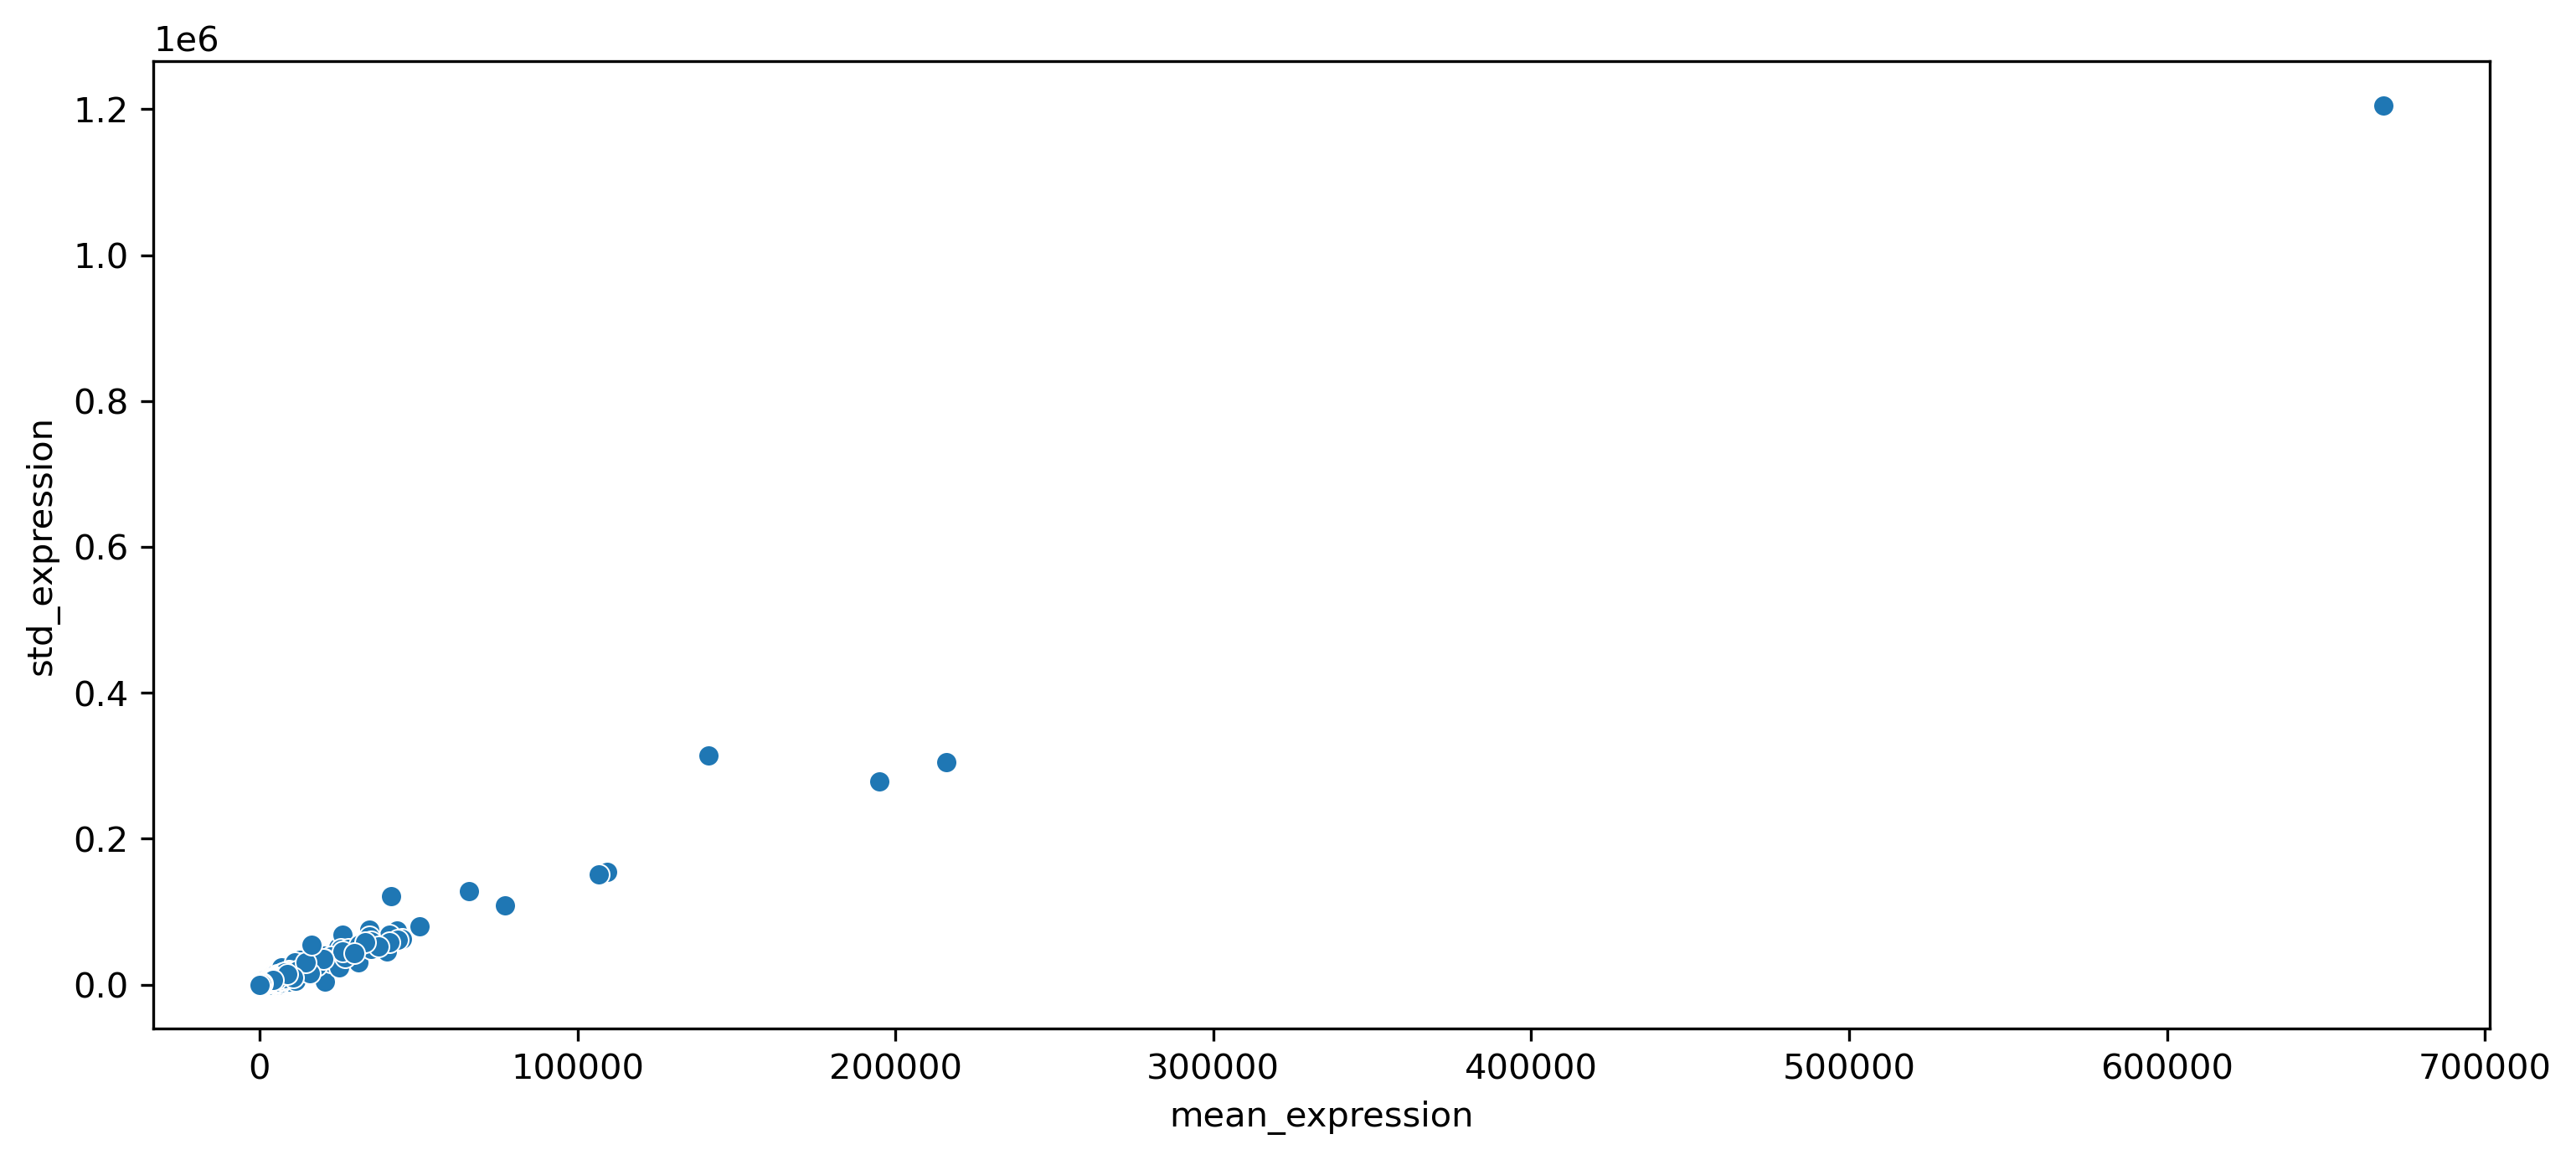

In [159]:
sns.scatterplot(
    data=pdf,
    x='mean_expression',
    y='std_expression',
)

In [153]:
# test = ['APC', 'CD44', 'CD59', 'MYADM', 'NCOR2', 'PRNP', 'THY1']
# table, pdf =aa iso.pivot_isoforms(df, genes=genes)

# pdf[pdf['gene_name'].isin(test)]

In [152]:
database = 'WikiPathway_2023_Human'
edf = gget.enrichr(test, database=database)
edf = edf[['path_name', 'adj_p_val', 'overlapping_genes']]
edf.head(10)

Thu Aug  1 15:28:07 2024 INFO Performing Enichr analysis using database WikiPathway_2023_Human.


,path_name,adj_p_val,overlapping_genes
0,Copper Homeostasis WP3286,0.005843,"[PRNP, APC]"
1,Complement System WP2806,0.007650,"[PRNP, CD59]"
2,Wnt Signaling Pathway And Pluripotency WP399,0.007650,"[APC, CD44]"
3,IL 24 Signaling Pathway WP5413,0.029784,"[APC, CD44]"
4,2Q21 1 Copy Number Variation Syndrome WP5223,0.038189,[APC]
5,Regulation Of Wnt B Catenin Signaling By Small...,0.038189,[APC]
6,Wnt Beta Catenin Signaling Pathway In Leukemia...,0.038189,[APC]
7,Pleural Mesothelioma WP5087,0.038189,"[APC, CD44]"
8,Gastric Cancer Network 1 WP2361,0.038189,[APC]
9,Extracellular Vesicle Mediated Signaling In Re...,0.038189,[APC]


In [133]:
?gget.enrichr

Signature:
gget.enrichr(
    genes,
    database,
    ensembl=False,
    plot=False,
    figsize=(10, 10),
    ax=None,
    json=False,
    save=False,
)
Docstring:
Perform an enrichment analysis on a list of genes using Enrichr (https://maayanlab.cloud/Enrichr/).

Args:
- genes       List of Entrez gene symbols to perform enrichment analysis on, passed as a list of strings, e.g. ['PHF14', 'RBM3', 'MSL1', 'PHF21A'].
              Set 'ensembl = True' to input a list of Ensembl gene IDs, e.g. ['ENSG00000106443', 'ENSG00000102317', 'ENSG00000188895'].
- database    Database to use as reference for the enrichment analysis.
              Supported shortcuts (and their default database):
              'pathway' (KEGG_2021_Human)
              'transcription' (ChEA_2016)
              'ontology' (GO_Biological_Process_2021)
              'diseases_drugs' (GWAS_Catalog_2019)
              'celltypes' (PanglaoDB_Augmented_2021)
              'kinase_interactions' (KEA_2015)
              or an

# quantify the variability?

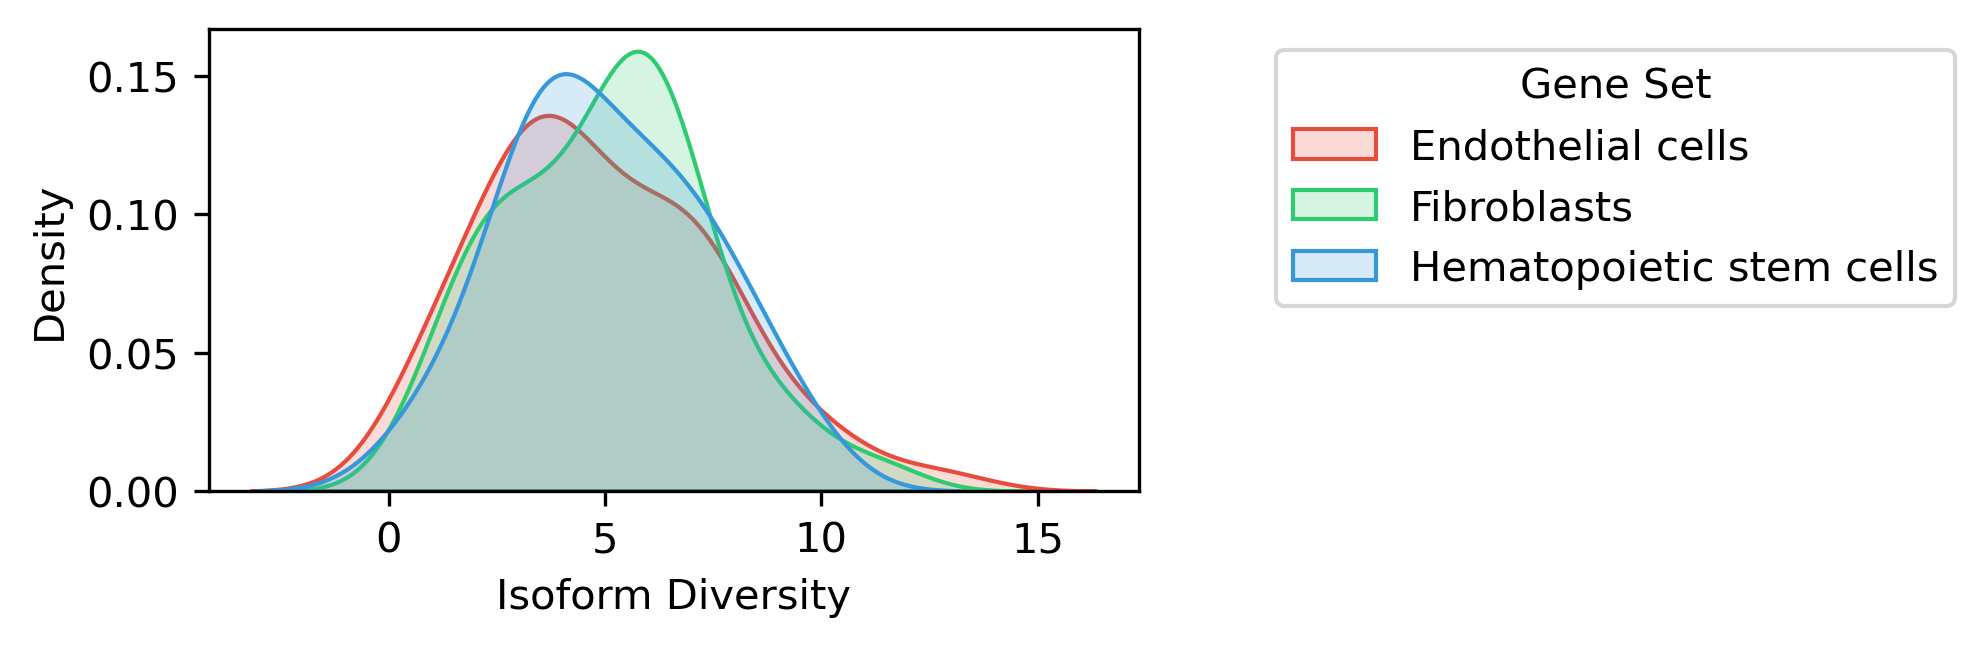

In [122]:
colors =  ['#E74C3C', '#2ECC71', '#3498DB']

for i, (cell_type, group) in enumerate(pangloa.groupby('cell_type')):
    
    marker_genes = list(group['gene_name'].unique())
    tmp = df[df['gene_name'].isin(marker_genes)]
    
    tmp = tmp.groupby('gene_name')['transcript_counts'].std()
    tmp = tmp[tmp > 0]
    tmp = tmp.apply(np.log1p)
    
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = 4, 2
    sns.kdeplot(
        data=tmp,
        label=cell_type,
        fill=True,
        alpha=0.2,  
        color=colors[i],
    )
    

plt.xlabel('Isoform Diversity')

plt.legend(
    loc='upper right',
    title='Gene Set',
    bbox_to_anchor=(1.9, 1)
)
plt.show()

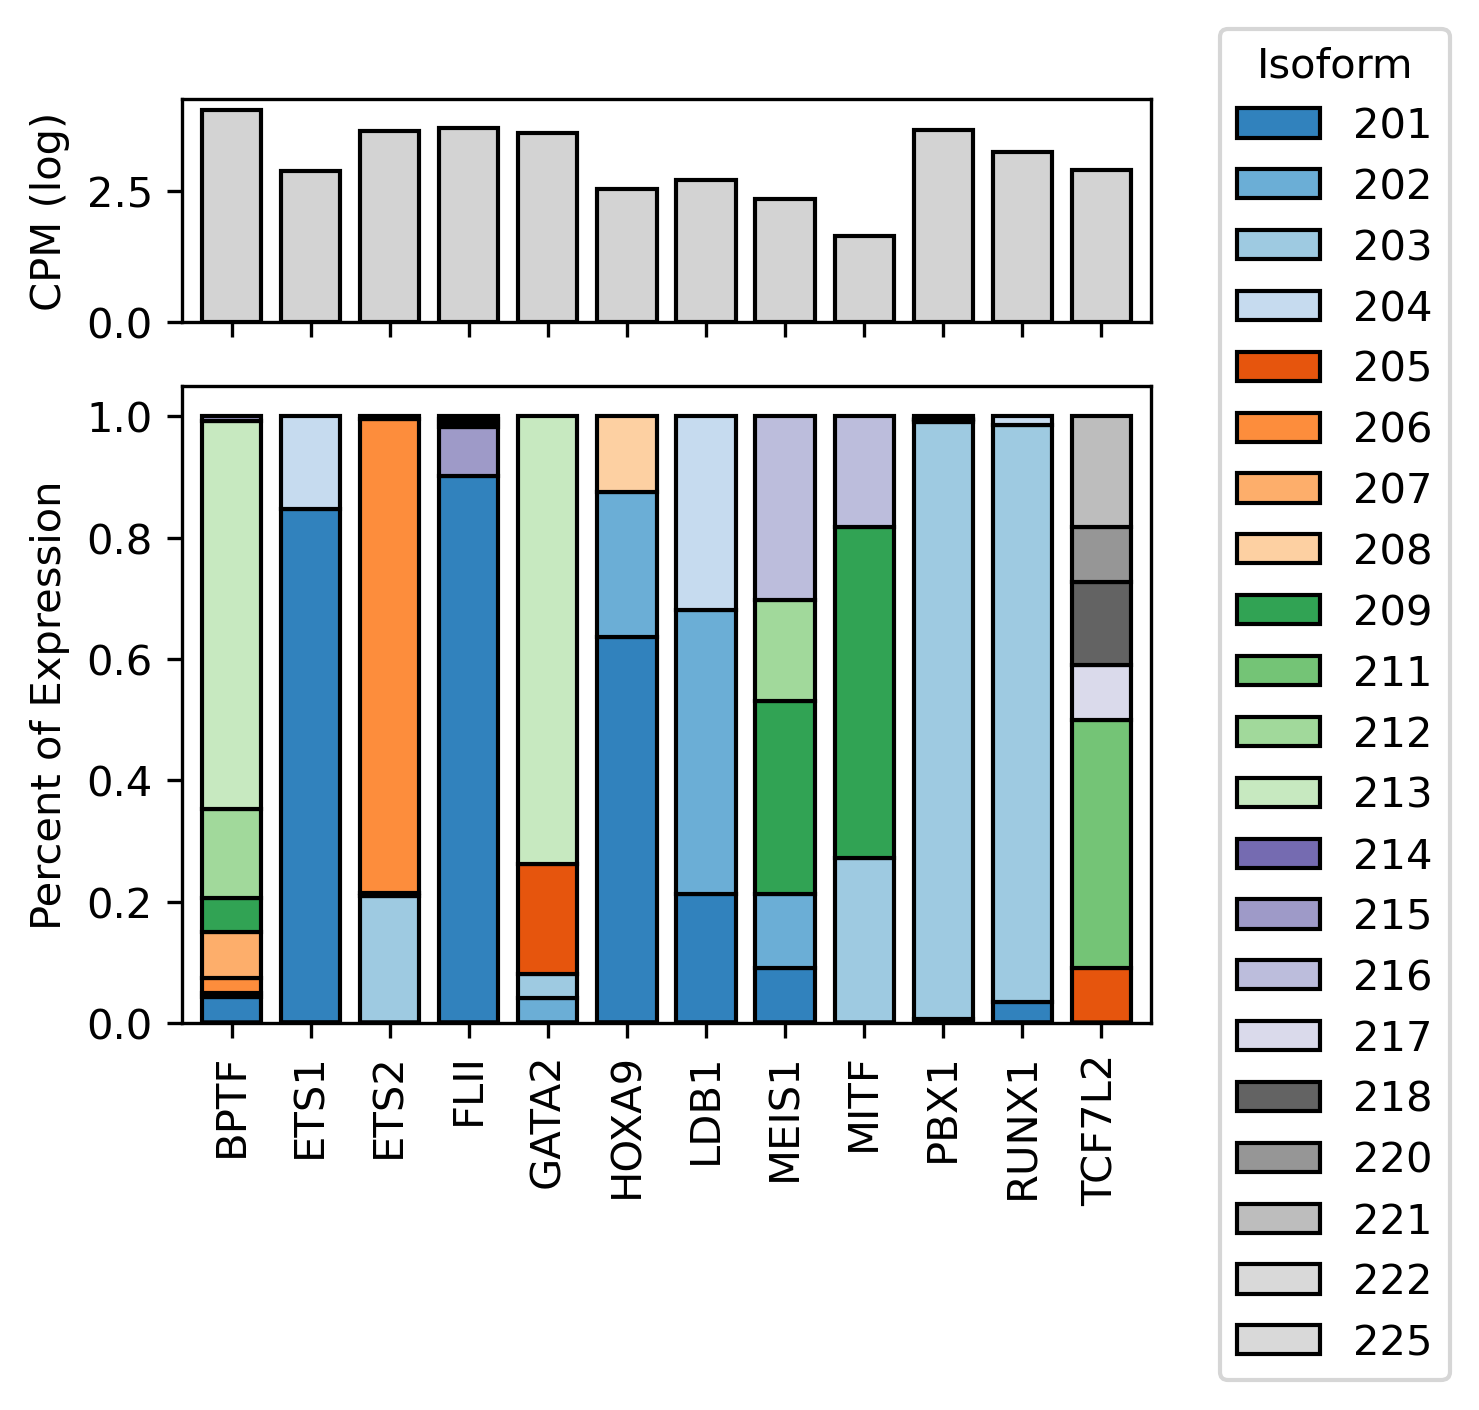

In [19]:
genes = [
 'TCF7L2','MITF', 'PRDM16', 'HOXA5',
 'HOXB4', 'GATA3', 'ETS1', 'ETS2',
 'PBX1', 'BPTF', 'HOXA9', 'FLII',
 'ERG', 'TAL1', 'MEIS1', 'LDB1',
 'GFI1B', 'IKZF1', 'RUNX1', 'HHEX',
 'SMARCC1', 'ETV6', 'NFE2', 'MYB',
 'GATA1', 'GATA2', 'LYL1', 'LMO2',   
]

pdf = df.copy()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 4
iso.plot_isoform_expression(df, 
                        genes, 
                        isoform_plot_kwargs={'cmap' : 'tab20c'},
                        count_threshold=1)

In [ ]:
genes = [
    'CD34',
    'CD164',
    'THY1',
]

pdf = df.copy()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 4
iso.plot_isoform_expression(df, 
                        genes, 
                        isoform_plot_kwargs={'cmap' : 'tab20c'},
                        count_threshold=1)

# Entropy

In [81]:
reload(iso)

pdf = df.copy()
pdf = iso.calculate_tx_percent(pdf, count_threshold=100)
pdf = iso.calculate_gene_entropy(pdf)
pdf = pdf.sort_values(by='entropy', ascending=False)
print(f"{pdf.shape=}")
pdf.head()

pdf.shape=(27618, 15)


,gene_id,gene_name,gene_biotype,transcript_id,transcript_name,transcript_biotype,gene_counts,transcript_counts,gene_CPM,log_CPM,n_isoforms,tid,short_name,tx_percent,entropy
22070,ENSG00000196141,SPATS2L,protein_coding,ENST00000360760,SPATS2L-202,protein_coding,8736,156,93.887061,4.552687,18,2,202,0.160494,3.47146
22074,ENSG00000196141,SPATS2L,protein_coding,ENST00000409397,SPATS2L-207,protein_coding,8736,9,93.887061,4.552687,18,6,207,0.009259,3.47146
22075,ENSG00000196141,SPATS2L,protein_coding,ENST00000409718,SPATS2L-208,protein_coding,8736,46,93.887061,4.552687,18,7,208,0.047325,3.47146
22071,ENSG00000196141,SPATS2L,protein_coding,ENST00000366118,SPATS2L-203,protein_coding,8736,7,93.887061,4.552687,18,3,203,0.007202,3.47146
22078,ENSG00000196141,SPATS2L,protein_coding,ENST00000423749,SPATS2L-211,protein_coding,8736,84,93.887061,4.552687,18,10,211,0.086420,3.47146


In [83]:
tdf = pdf.copy()
tdf = tdf[['gene_name', 'entropy']].drop_duplicates()
tdf.head(15)

,gene_name,entropy
22070,SPATS2L,3.471460
4302,CEP57L1,3.461581
11465,ITGB1,3.434748
10487,HNRNPC,3.389041
9652,GOSR2,3.284395
6592,DLG1,3.262830
13064,MATR3,3.235547
3376,CAST,3.205472
23266,TCF4,3.203914
21596,SMARCA2,3.187494


In [84]:
n_genes = 30
database = 'TRRUST_Transcription_Factors_2019'
# database = 'TRANSFAC_and_JASPAR_PWMs'

edf = gget.enrichr(tdf['gene_name'].head(n_genes).values, database=database)

for _, row in edf.head(10).iterrows():
    print(f"{row['adj_p_val']:.4}", row['path_name'], row['overlapping_genes'])

Thu Aug  1 13:17:15 2024 INFO Performing Enichr analysis using database TRRUST_Transcription_Factors_2019.


0.0106 TP63 human ['TCF4', 'BRCA1']
0.05995 SOX4 mouse ['TCF4']
0.05995 E2F6 human ['BRCA1']
0.05995 NCOA3 human ['BRCA1']
0.05995 FOXF2 human ['ITGB1']
0.05995 CUX1 human ['RACGAP1']
0.05995 E2F4 mouse ['BRCA1']
0.05995 RBL2 mouse ['BRCA1']
0.05995 MEN1 human ['BRCA1']
0.05995 FOXP3 human ['BRCA1']


In [ ]:
n_genes = 30
database = 'TRANSFAC_and_JASPAR_PWMs'

edf = gget.enrichr(tdf['gene_name'].head(n_genes).values, database=database)

for _, row in edf.head(10).iterrows():
    print(f"{row['adj_p_val']:.4}", row['path_name'], row['overlapping_genes'])

In [ ]:
genes = [
    'CD34',
    'CD164',
    'THY1',
    'GATA2',
    'STAT5A',
    'REL',
    'FOS',
]

mask = tdf['gene_name'].isin(genes)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2

sns.barplot(data=tdf[mask],
            x='gene_name',
            y='entropy',
            ec='k')

plt.gca().tick_params(axis='x', rotation=90)

In [ ]:
pdf = df.copy()
pdf = iso.calculate_tx_percent(pdf, count_threshold=100)
pdf = iso.calculate_gene_entropy(pdf)
pdf = pdf.sort_values(by='entropy', ascending=False)
print(f"{pdf.shape=}")
pdf = iso.extract_gene_data(pdf)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(data=pdf, 
                x='log_CPM',
                y='entropy',
                ec='none',
                color="grey",
                alpha=0.75,
                s=1,
               )

pdf.head()

In [ ]:
# break

# cell type specic isoform entropy

pangloa.shape=(1434, 7)
pangloa.shape=(394, 7)


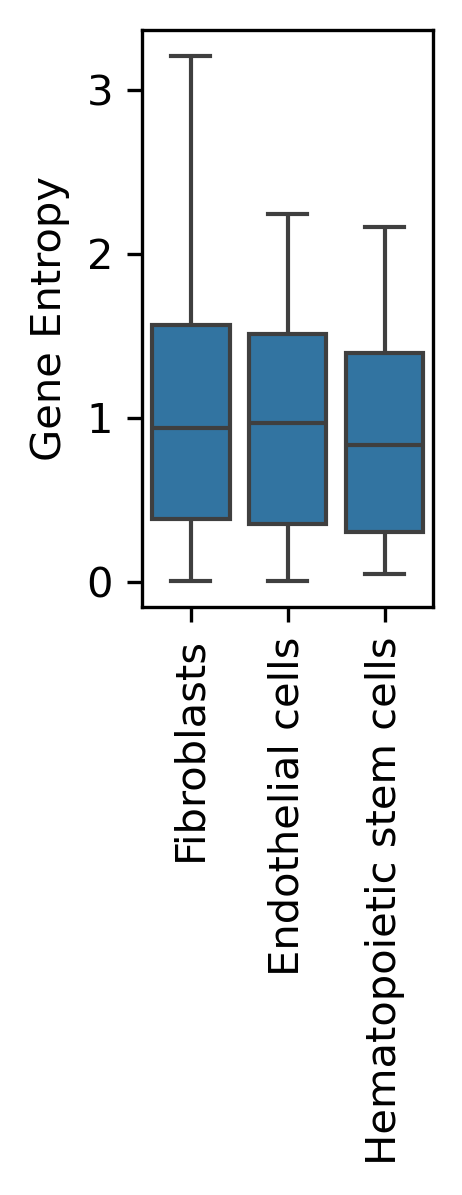

In [85]:
pangloa = pd.read_csv("/home/cstansbu/git_repositories/ONT-single-cell/config/gene_annotations/panglaodb.csv")
print(f"{pangloa.shape=}")
pangloa = pangloa[~pangloa['gene_name'].duplicated()]

cell_types = [
    "Endothelial cells",
    "Fibroblasts",
    "Hematopoietic stem cells",
]

pangloa = pangloa[pangloa['cell_type'].isin(cell_types)]

gene_mapper = dict(zip(pangloa.gene_name, pangloa.cell_type))
print(f"{pangloa.shape=}")

tdf['cell_type'] = tdf['gene_name'].map(gene_mapper)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.25, 2.5


sns.boxplot(data=tdf, 
            x='cell_type',
            y='entropy')

plt.ylabel("Gene Entropy")
plt.xlabel("")
plt.gca().tick_params(axis='x', rotation=90)


# GATA2

In [86]:
pdf = df.copy()
pdf = pdf[pdf['gene_name'] == 'GATA2']

pdf

,gene_id,gene_name,gene_biotype,transcript_id,transcript_name,transcript_biotype,gene_counts,transcript_counts,gene_CPM,log_CPM,n_isoforms,tid,short_name
55731,ENSG00000179348,GATA2,protein_coding,ENST00000430265,GATA2-202,protein_coding,3297,19,35.433338,3.595484,4,1,202
55732,ENSG00000179348,GATA2,protein_coding,ENST00000487848,GATA2-203,protein_coding,3297,19,35.433338,3.595484,4,2,203
55733,ENSG00000179348,GATA2,protein_coding,ENST00000492608,GATA2-205,protein_coding,3297,84,35.433338,3.595484,4,3,205
55727,ENSG00000179348,GATA2,protein_coding,ENST00000696672,GATA2-213,protein_coding,3297,342,35.433338,3.595484,4,4,213


In [87]:
sdf = grn.load_scenic_database()
sdf.head()

,ABL1,ACAA1,ADNP,ADNP2,AEBP2,AFF4,AHCTF1,AHDC1,AHR,AHRR,...,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSCAN5C,ZSCAN9,ZXDA,ZXDB,ZXDC,ZZZ3
gene_name,,,,,,,,,,,,,,,,,,,,,
A1BG,1.65,0.0,5.060,0.0,0.0,8.470,6.400,2.290,0.83060,0.0,...,0.0,0.0,0.0,0.0,1.32,1.448,1.790,1.484333,0.0,1.37
A1BG-AS1,0.00,0.0,0.545,0.0,0.0,0.379,0.000,0.000,0.14640,0.0,...,0.0,0.0,0.0,0.0,0.00,0.770,1.465,1.032333,0.0,0.00
A1CF,1.55,0.0,0.000,0.0,0.0,3.780,4.880,1.092,0.31400,0.0,...,0.0,0.0,0.0,0.0,0.00,0.920,2.865,1.910000,0.0,2.67
A2M,1.39,0.0,0.827,0.0,0.0,4.700,0.810,1.055,0.27314,0.0,...,0.0,0.0,0.0,0.0,0.00,0.535,0.885,0.698000,0.0,3.45
A2M-AS1,0.00,0.0,0.000,0.0,0.0,1.450,0.111,0.000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.00,0.800,0.000,0.059333,0.0,0.00


In [88]:
query = 'GATA2'
quantile = 0.99    
targets = grn.get_targets(sdf, query, quantile)
print(len(targets))

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
pdf = df.copy()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 5
iso.plot_isoform_expression(df, 
                        targets, 
                        count_threshold=5000)

# GO annotations

In [ ]:
genes = pd.read_csv("/home/cstansbu/git_repositories/ONT-single-cell/config/gene_annotations/go_annotations.csv")
print(genes['go_biological_process'].value_counts())

pathway = 'hematopoietic stem cell homeostasis'
genes = genes[genes['go_biological_process'] == pathway]
genes = genes['gene_name'].unique()
print(sorted(genes))
print(len(genes))

iso.plot_isoform_expression(df, 
                        genes, 
                        count_threshold=1)

plt.suptitle(pathway.title())
sorted(genes)

# Network Plot

In [ ]:
genes = pd.read_csv("/home/cstansbu/git_repositories/ONT-single-cell/config/gene_annotations/go_annotations.csv")
print(genes['go_biological_process'].value_counts())

pathway = 'hematopoietic stem cell homeostasis'
genes = genes[genes['go_biological_process'] == pathway]
genes = genes['gene_name'].unique()
print(sorted(genes))
print(len(genes))

pdf = df.copy()
pdf = iso.calculate_tx_percent(pdf, genes=genes, count_threshold=1)
pdf = iso.calculate_gene_entropy(pdf)
pdf = pdf.sort_values(by='entropy', ascending=False)
print()
print(sorted(pdf['gene_name'].unique()))
pdf.head()

In [ ]:
# loaad the scenic database
sdf = grn.load_scenic_database()
sdf.head()

In [89]:
# build regulatory network from SCNENIC
reload(iso)
reload(grn)

genes_only = iso.extract_gene_data(pdf)
G = grn.create_scenic_network(genes_only, sdf)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 8

grn.visualize_network(G)

plt.title("Hematopoietic stem cell homeostasis")

KeyError: "['entropy'] not in index"

# Archive

In [ ]:
break

In [ ]:
# def plot_scenic_network(
#     G,
#     node_size_scale=1000,
#     node_color="lightblue",
#     tf_color="orange",
#     edge_color="k",
#     label_nodes=True,
#     font_size=8,
#     k=5,  # Spring layout parameter for spacing
#     iterations=100,
# ):
#     """Plots a SCENIC gene regulatory network with customizable aesthetics.

#     Args:
#         G (nx.DiGraph): The directed network to plot.
#         figsize (tuple): The size of the figure (width, height). Default is (10, 10).
#         node_size_scale (float): Scaling factor for node size based on expression. Default is 50.
#         node_color (str): Color of the nodes. Default is "lightblue".
#         tf_color (str): Color of transcription factor nodes. Default is "orange".
#         edge_color (str): Color of the edges. Default is "grey".
#         label_nodes (bool): Whether to label nodes. Default is True.
#         font_size (int): Font size for node labels. Default is 8.
#         layout (str): Layout algorithm to use. Options: "spring" (default), "kamada_kawai", "circular".
#         k (float): Optimal distance between nodes in spring layout (higher values increase spacing). Default is 0.8.
#         iterations (int): Number of iterations for the spring layout algorithm. Default is 100.
#     """
    
#     # Node positions using Kamada-Kawai layout
#     pos = nx.kamada_kawai_layout(G)

#     # Node sizes based on gene expression (using log_CPM)
#     node_sizes = [G.nodes[n].get("log_CPM", 0) * node_size_scale + 50 for n in G.nodes]

#     # Identifying transcription factor nodes (you may need to customize this based on your data)
#     tf_nodes = [n for n in G.nodes if G.nodes[n].get("is_tf", False)]

#     # --- Separate drawing of node types ---
    
#     # Draw regular gene nodes
#     regular_nodes = [n for n in G.nodes if n not in tf_nodes]
#     nx.draw_networkx_nodes(
#         G,
#         pos,
#         nodelist=regular_nodes,
#         node_size=[node_sizes[i] for i, n in enumerate(G.nodes) if n not in tf_nodes],
#         node_color=node_color,
#         node_shape="o",
#         linewidths=0.5,
#         edgecolors="black",  
#     )

#     # Draw transcription factor nodes
#     nx.draw_networkx_nodes(
#         G,
#         pos,
#         nodelist=tf_nodes,
#         node_size=[node_sizes[i] for i, n in enumerate(G.nodes) if n in tf_nodes],
#         node_color=tf_color,
#         node_shape="s",
#         linewidths=0.5,
#         edgecolors="black",
#     )
    
#     # --- Draw edges with arrows stopping at node boundary ---
    
#     # This part is tricky due to Matplotlib's node drawing logic
#     # We'll approximate it for now (perfect solution may require custom arrow drawing)

#     # Draw edges with width proportional to weight
#     edge_weights = nx.get_edge_attributes(G, "weight")
#     nx.draw_networkx_edges(
#         G,
#         pos,
#         width=[edge_weights[e] * 0.5 for e in G.edges()],
#         edge_color=edge_color,
#         arrows=True,
#         arrowstyle="-|>",  # This arrow style stops closer to the node
#         arrowsize=10,     # Adjust for finer control
#     )    

#     # Label nodes
#     if label_nodes:
#         nx.draw_networkx_labels(G, pos, font_size=font_size)

#     plt.axis("off")
#     plt.title("SCENIC Gene Regulatory Network")
#     plt.show()
    
    
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 10, 10
# plot_scenic_network(G)

In [ ]:
break

In [ ]:
# def visualize_isoform_network(df, gene_node_size=2000, tx_percent_scale=1000,
#                               gene_color='skyblue', transcript_color='lightcoral',
#                               gene_node_shape='s', transcript_node_shape='o',
#                               node_kwargs={}, edge_kwargs={}, label_kwargs={}):
#     """
#     Visualizes a gene-isoform network with enhanced clarity and scalability,
#     drawing all genes in one color and all transcripts in another.

#     Args:
#         df: pandas DataFrame containing gene_name, short_name (transcript name), and tx_percent columns.
#         gene_node_size: Base size of gene nodes (default: 2500).
#         tx_percent_scale: Scaling factor for transcript node size based on tx_percent (default: 3000).
#         gene_color: Color for gene nodes (default: 'skyblue').
#         transcript_color: Color for transcript nodes (default: 'lightcoral').
#         gene_node_shape: Shape for gene nodes (default: 's' for square).
#         transcript_node_shape: Shape for transcript nodes (default: 'o' for circle).
#         node_kwargs: Additional keyword arguments to pass to nx.draw_networkx_nodes.
#         edge_kwargs: Additional keyword arguments to pass to nx.draw_networkx_edges.
#         label_kwargs: Additional keyword arguments to pass to nx.draw_networkx_labels.
#     """

#     G = nx.Graph()

#     # --- Add Nodes ---
#     for gene in df['gene_name'].unique():
#         G.add_node(gene, size=gene_node_size, color=gene_color, shape=gene_node_shape)
    
#     for _, row in df.iterrows():
#         G.add_node(row['short_name'], size=row['tx_percent'] * tx_percent_scale, 
#                    color=transcript_color, shape=transcript_node_shape)
#         G.add_edge(row['gene_name'], row['short_name'])

#     # --- Separate Drawing ---
#     gene_nodes = [n for n in G.nodes() if n in df['gene_name'].unique()]
#     transcript_nodes = [n for n in G.nodes() if n not in df['gene_name'].unique()]
    
    
#     # --- Layout & Drawing ---
#     pos = nx.kamada_kawai_layout(G) # More visually appealing layout for larger graphs
#     # Use bipartite layout if you prefer to have genes and transcripts in two separate lines.
#     # pos = nx.bipartite_layout(G, gene_nodes)

#     nx.draw_networkx_nodes(G, pos, nodelist=gene_nodes,
#                            node_size=gene_node_size,  
#                            node_color=gene_color,
#                            node_shape=gene_node_shape, **node_kwargs)

#     nx.draw_networkx_nodes(G, pos, nodelist=transcript_nodes,
#                            node_size=[G.nodes[n]['size'] for n in transcript_nodes],
#                            node_color=transcript_color,
#                            node_shape=transcript_node_shape, **node_kwargs)

#     nx.draw_networkx_edges(G, pos, **edge_kwargs)
#     nx.draw_networkx_labels(G, pos, **label_kwargs)

# visualize_isoform_network(pdf)

In [ ]:
break